# Boost vs 딥러닝


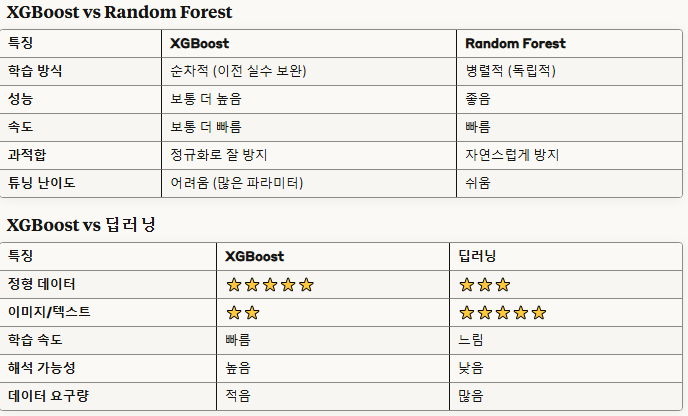

| 컬럼명(예시) | 설명                                            |
| ------- | --------------------------------------------- |
| 연도      | 해당 기록이 속한 시즌/년도 (예: 2021, 2022)               |
| 팀명      | 소속 팀 (예: 두산, LG, 삼성 등)                        |
| G       | 경기수 (Games)                                   |
| PA      | 타석수 (Plate Appearances) — 출루/진루 등 모든 타석 포함    |
| AB      | 타수 (At Bats) — 실제로 타격이 결과를 만든 타석 수            |
| R       | 득점 (Runs) — 홈 플레이트를 밟아 점수 기록한 횟수              |
| H       | 안타 (Hits) — 1루 이상 진루 성공한 타격 수                 |
| 2B      | 2루타 (Doubles) — 2루까지 진루한 안타 수                 |
| 3B      | 3루타 (Triples) — 3루까지 진루한 안타 수                 |
| HR      | 홈런 (Home Runs) — 한 번의 타격으로 홈런 친 횟수            |
| TB      | 루타수 (Total Bases) — 안타에 따른 누적 베이스 수           |
| RBI     | 타점 (Runs Batted In) — 자신의 타격으로 주자가 득점한 횟수     |
| SB      | 도루 (Stolen Bases) — 1루, 2루, 3루 등 도루 성공 횟수     |
| CS      | 도루실패 (Caught Stealing) — 도루 시도 후 실패한 횟수       |
| BB      | 볼넷 (Base on Balls, Walks) — 투수가 볼 4개 던져 출루    |
| HBP     | 몸에 맞는 볼 (Hit By Pitch) — 사구 출루                |
| SO      | 삼진 (Strike Outs) — 아웃된 삼진 횟수                  |
| GDP     | 병살타 (Grounded into Double Play) — 한 타격으로 2아웃  |
| OBP     | 출루율 (On-base Percentage) — 출루 비율, 0.350 등 소수값 |
| SLG     | 장타율 (Slugging Percentage) — 장타 능력, 0.500 등    |
| AVG     | 타율 (Batting Average) — 안타/타수 비율, 0.300 등      |
| OPS     | 출루율+장타율 (On-base Plus Slugging) — 0.850 등     |
| ...     | 기타 (예: 희생플라이, 희생번트, 병살타, 타점, 득점권 등)           |


In [1]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [2]:
import matplotlib.pyplot as plt

# 폰트 설정
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

   year           team  average_batter_age  runs_per_game  games  \
0  2021    SSG Landers                30.9           5.26    143   
1  2021   Doosan Bears                29.0           5.13    143   
2  2021   Lotte Giants                29.0           5.06    143   
3  2021  Kiwoom Heroes                27.1           5.01    143   
4  2021         KT Wiz                29.4           4.97    143   

   plate_appearances  at_bats  runs  hits  doubles  ...  batting_average  \
0               5698     4864   752  1268      203  ...            0.261   
1               5606     4867   733  1306      234  ...            0.268   
2               5689     4978   723  1384      263  ...            0.278   
3               5610     4839   716  1250      243  ...            0.258   
4               5581     4773   711  1263      217  ...            0.265   

     OBP    SLG    OPS  total_bases  GDP  HBP  sacrifice_hits  \
0  0.354  0.421  0.775         2049  104   93              55   
1  0

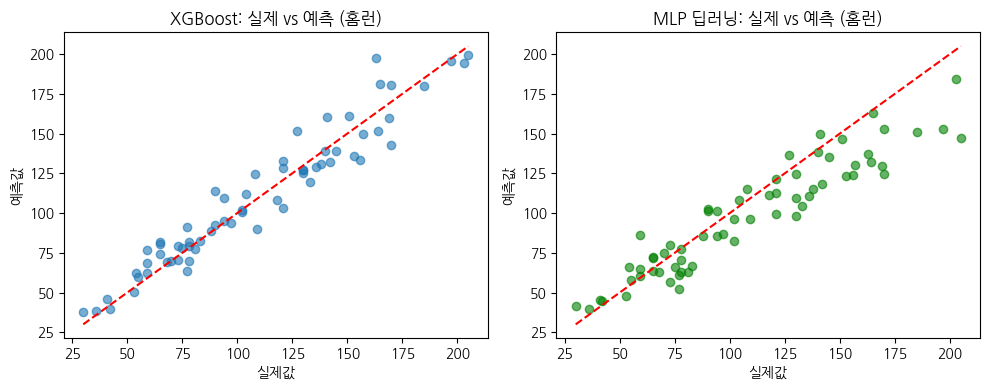

In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# 1. 데이터 로드
df = pd.read_csv('/content/kbobattingdata.csv')
print(df.head())
print("컬럼:", df.columns)

# 2. 타깃/피처 지정 (홈런 예측)
target_col = 'homeruns'   # 'homeruns'이 홈런수 컬럼명임을 가정
drop_cols = [target_col]
features = [c for c in df.columns if c not in drop_cols]

# 3. 연도, 팀명 문자형 처리(LabelEncoding)
from sklearn.preprocessing import LabelEncoder
for col in ['year', 'team']:
    if col in features:
        df[col] = df[col].astype(str)
        df[col] = LabelEncoder().fit_transform(df[col])

# 4. 결측치 처리 (수치형: 평균)
# Identify numeric columns for mean imputation
numeric_cols = df[features].select_dtypes(include=np.number).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

X = df[features]
y = df[target_col]

# 5. train/test 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. XGBoost 회귀모델
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=70, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("\n[ XGBoost - 홈런 예측 ]")
print("MSE:", mean_squared_error(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("R2:", r2_score(y_test, y_pred_xgb))

# 7. 딥러닝(MLP) 회귀모델 (PyTorch)


class BattingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = BattingDataset(X_train, y_train)
test_ds = BattingDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_model = MLP(X.shape[1])
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(50):
    mlp_model.train()
    for xb, yb in train_loader:
        pred = mlp_model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

mlp_model.eval()
y_pred_mlp = []
with torch.no_grad():
    for xb, yb in test_loader:
        y_pred_mlp.extend(mlp_model(xb).view(-1).tolist())
y_pred_mlp = np.array(y_pred_mlp)

print("\n[ MLP 딥러닝 - 홈런 예측 ]")
print("MSE:", mean_squared_error(y_test, y_pred_mlp))
print("MAE:", mean_absolute_error(y_test, y_pred_mlp))
print("R2:", r2_score(y_test, y_pred_mlp))

# 8. 실제 vs 예측 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_xgb, alpha=0.6)
plt.title("XGBoost: 실제 vs 예측 (홈런)")
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_mlp, alpha=0.6, color='green')
plt.title("MLP 딥러닝: 실제 vs 예측 (홈런)")
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()